# Walmart Sales Forecasting

## In Depth Analysis

Daniel Lee

December 19, 2018

For the in-depth analysis portion, I read in `df_final.csv` from the data wrangling portion of the project.

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from math import sqrt
from statsmodels.tsa import stattools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA, ARIMA
from sklearn.linear_model import Ridge, Lasso
import statsmodels.tsa.api as smtsa
import statsmodels.api as sm
import warnings
from sqlalchemy import create_engine
from pyspark.sql import SparkSession
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy import sparse
import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from keras.models import Sequential
from keras import regularizers
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import pickle

/root/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.


# Predict Individual Weekly_Sales For Every Unique Store, Dept, and Date

In [15]:
df_final = pd.read_csv('../data/df_final.csv')

In [16]:
simple_model_features = pd.read_csv('../data/simple_model_features.csv')

In [17]:
simple_model_features = simple_model_features[['store', 'dept', 'date', 'median_sales', 'prev_year_sales', 'pdt_pred']]

In [18]:
simple_model_features.columns = ['store', 'dept', 'date', 'median_sales_redone', 'prev_year_sales', 'pdt_pred']

In [19]:
df_final = pd.merge(df_final, simple_model_features, on = ['store', 'dept', 'date'])

# Split Data Into Training Set and Test Set

Let's split our processed data into training set, validation set, and test set. We'll use the training set to fit our models, validation set to evaluate the model performance. Then, we'll use the test set to make predictions and submit to Kaggle. 

In [20]:
train = df_final.loc[df_final.source == 'train']

test = df_final.loc[df_final.source == 'test']

In [21]:
wanted_X_col = [\
#  'type',
#  'dept',
#  'store',
#  'month',
#  'is_holiday',
#  'week_of_year',
#  'date',
#  'weekly_sales',
#  'temperature',
#  'fuel_price',
#  'markdown1',
#  'markdown2',
#  'markdown3',
#  'markdown4',
#  'markdown5',
#  'cpi',
#  'unemployment',
 'size',
#  'source',
#  'markdown1_median',
#  'markdown2_median',
#  'markdown3_median',
#  'markdown4_median',
#  'markdown5_median',
#  'markdown1_median_filled_na',
#  'markdown2_median_filled_na',
#  'markdown3_median_filled_na',
#  'markdown4_median_filled_na',
#  'markdown5_median_filled_na',
#  'markdown1_filled_na',
#  'markdown2_filled_na',
#  'markdown3_filled_na',
#  'markdown4_filled_na',
#  'markdown5_filled_na',
#  'md1_present',
#  'md2_present',
#  'md3_present',
#  'md4_present',
#  'md5_present',
#  'cpi_filled',
#  'unemployment_filled',
#  'store_relabel',
#  'dept_relabel',
#  'type_relabel',
#  'week_of_year_relabel',
#  'month_relabel',
#  'is_holiday_relabel',
#  'black_friday',
#  'pre_christmas',
 'store_1',
 'store_10',
 'store_11',
 'store_12',
 'store_13',
 'store_14',
 'store_15',
 'store_16',
 'store_17',
 'store_18',
 'store_19',
 'store_2',
 'store_20',
 'store_21',
 'store_22',
 'store_23',
 'store_24',
 'store_25',
 'store_26',
 'store_27',
 'store_28',
 'store_29',
 'store_3',
 'store_30',
 'store_31',
 'store_32',
 'store_33',
 'store_34',
 'store_35',
 'store_36',
 'store_37',
 'store_38',
 'store_39',
 'store_4',
 'store_40',
 'store_41',
 'store_42',
 'store_43',
 'store_44',
 'store_45',
 'store_5',
 'store_6',
 'store_7',
 'store_8',
 'store_9',
 'dept_1',
 'dept_10',
 'dept_11',
 'dept_12',
 'dept_13',
 'dept_14',
 'dept_16',
 'dept_17',
 'dept_18',
 'dept_19',
 'dept_2',
 'dept_20',
 'dept_21',
 'dept_22',
 'dept_23',
 'dept_24',
 'dept_25',
 'dept_26',
 'dept_27',
 'dept_28',
 'dept_29',
 'dept_3',
 'dept_30',
 'dept_31',
 'dept_32',
 'dept_33',
 'dept_34',
 'dept_35',
 'dept_36',
 'dept_37',
 'dept_38',
 'dept_39',
 'dept_4',
 'dept_40',
 'dept_41',
 'dept_42',
 'dept_43',
 'dept_44',
 'dept_45',
 'dept_46',
 'dept_47',
 'dept_48',
 'dept_49',
 'dept_5',
 'dept_50',
 'dept_51',
 'dept_52',
 'dept_54',
 'dept_55',
 'dept_56',
 'dept_58',
 'dept_59',
 'dept_6',
 'dept_60',
 'dept_65',
 'dept_67',
 'dept_7',
 'dept_71',
 'dept_72',
 'dept_74',
 'dept_77',
 'dept_78',
 'dept_79',
 'dept_8',
 'dept_80',
 'dept_81',
 'dept_82',
 'dept_83',
 'dept_85',
 'dept_87',
 'dept_9',
 'dept_90',
 'dept_91',
 'dept_92',
 'dept_93',
 'dept_94',
 'dept_95',
 'dept_96',
 'dept_97',
 'dept_98',
 'dept_99',
 'type_A',
 'type_B',
 'type_C',
 'week_of_year_1',
 'week_of_year_10',
 'week_of_year_11',
 'week_of_year_12',
 'week_of_year_13',
 'week_of_year_14',
 'week_of_year_15',
 'week_of_year_16',
 'week_of_year_17',
 'week_of_year_18',
 'week_of_year_19',
 'week_of_year_2',
 'week_of_year_20',
 'week_of_year_21',
 'week_of_year_22',
 'week_of_year_23',
 'week_of_year_24',
 'week_of_year_25',
 'week_of_year_26',
 'week_of_year_27',
 'week_of_year_28',
 'week_of_year_29',
 'week_of_year_3',
 'week_of_year_30',
 'week_of_year_31',
 'week_of_year_32',
 'week_of_year_33',
 'week_of_year_34',
 'week_of_year_35',
 'week_of_year_36',
 'week_of_year_37',
 'week_of_year_38',
 'week_of_year_39',
 'week_of_year_4',
 'week_of_year_40',
 'week_of_year_41',
 'week_of_year_42',
 'week_of_year_43',
 'week_of_year_44',
 'week_of_year_45',
 'week_of_year_46',
 'week_of_year_47',
 'week_of_year_48',
 'week_of_year_49',
 'week_of_year_5',
 'week_of_year_50',
 'week_of_year_51',
 'week_of_year_52',
 'week_of_year_6',
 'week_of_year_7',
 'week_of_year_8',
 'week_of_year_9',
 'month_1',
 'month_10',
 'month_11',
 'month_12',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'is_holiday_false',
 'is_holiday_true',
 'black_friday_no',
 'black_friday_yes',
 'pre_christmas_no',
 'pre_christmas_yes',
#  'median_sales',
#  'median_sales_fillna',
#  'previous_week',
#  'next_week',
#  'previous_weekly_sales',
 'sales_diff',
#  'weekly_sales_na_filled',
#  'value_to_predict',
 'lagged_available',
 'previous_weekly_sales_scaled',
#  'sales_diff_scaled',
 'temperature_scaled',
 'fuel_price_scaled',
 'markdown1_filled_na_scaled',
 'markdown2_filled_na_scaled',
 'markdown3_filled_na_scaled',
 'markdown4_filled_na_scaled',
 'markdown5_filled_na_scaled',
 'cpi_filled_scaled',
 'unemployment_filled_scaled',
               'median_sales_redone', 'prev_year_sales', 'pdt_pred']

In [22]:
# Set seed for reproducability 
SEED = 42
np.random.seed(SEED)
X_train, X_val, y_train, y_val = train_test_split(train[wanted_X_col], 
                                                  train['value_to_predict'], 
                                                  test_size=0.2, 
                                                  random_state= SEED)
print(X_val.shape)
print(y_val.shape)

(84314, 215)
(84314,)


In [23]:
X_test = test[wanted_X_col]

In [8]:
X_train.describe()

,size,store_1,store_10,store_11,store_12,store_13,store_14,store_15,store_16,store_17,...,previous_weekly_sales_scaled,temperature_scaled,fuel_price_scaled,markdown1_filled_na_scaled,markdown2_filled_na_scaled,markdown3_filled_na_scaled,markdown4_filled_na_scaled,markdown5_filled_na_scaled,cpi_filled_scaled,unemployment_filled_scaled
count,337256.000000,337256.000000,337256.000000,337256.000000,337256.000000,337256.000000,337256.000000,337256.000000,337256.000000,337256.000000,...,337256.000000,337256.000000,337256.000000,337256.000000,337256.000000,337256.000000,337256.000000,337256.000000,337256.000000,337256.000000
mean,136811.628614,0.024255,0.024501,0.024011,0.023074,0.024865,0.023851,0.023306,0.022348,0.023424,...,0.000705,0.070674,-0.111870,-0.000549,-0.024504,-0.025401,0.007145,0.007754,-0.126769,0.108531
std,60981.743057,0.153839,0.154598,0.153085,0.150140,0.155715,0.152586,0.150873,0.147813,0.151247,...,1.002870,0.987031,1.064583,0.933848,0.976185,0.870869,0.955494,0.638715,0.949807,1.035236
min,34875.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.923577,-3.256742,-2.173112,-0.954541,-0.361373,-0.143131,-0.500244,-0.391600,-1.221934,-2.159869
25%,93638.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.611843,-0.646284,-1.105483,-0.590129,-0.321715,-0.133170,-0.445797,-0.221214,-1.077406,-0.486533
50%,140167.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.368301,0.178719,0.101402,-0.228579,-0.304073,-0.130559,-0.288940,-0.093494,0.143311,0.055134
75%,202505.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.186111,0.829192,0.762867,0.229180,-0.198240,-0.121428,0.048027,0.092792,0.872564,0.447357
max,219622.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,29.841893,2.214726,2.459469,9.169701,14.875178,14.967527,10.202394,35.418318,1.231923,3.636805


# Neural Networks Implementation

The following neural network implemention is from [here](https://www.kaggle.com/fernandol/cracking-the-walmart-sales-forecasting-challenge?scriptVersionId=3025467).

In [206]:
X_train.shape

(337256, 212)

In [207]:
X_train.shape[1]

212

In [24]:
# Sequential model
adam_regularized = Sequential()

# First hidden layer now regularized
adam_regularized.add(Dense(212, activation='relu',
                input_dim=X_train.shape[1]))

# Second hidden layer now regularized
adam_regularized.add(Dense(106, activation='relu'))

# Third hidden layer now regularized
adam_regularized.add(Dense(53, activation='relu'))

# Output layer stayed sigmoid
adam_regularized.add(Dense(1))

# Setup adam optimizer
adam_optimizer=keras.optimizers.Adam(lr=0.01,
                beta_1=0.9, 
                beta_2=0.999, 
                epsilon=1e-08)

# Compile the model
adam_regularized.compile(optimizer='adam',
              loss='mean_absolute_error',
              metrics=['acc'])

# early stopping
early_stopping_monitor = EarlyStopping(patience = 5)

# Train
history_adam_regularized=adam_regularized.fit(X_train, y_train, # Train on training set
                             epochs=1000, # We will train over 1,000 epochs
                             batch_size=2048, # Batch size 
                             verbose=1, 
                             callbacks = [early_stopping_monitor],
                             validation_data = (X_val, y_val)) # early stop fitting if no improvement in 5 epochs

adam_regularized.evaluate(x=X_val,y=y_val)

Train on 337256 samples, validate on 84314 samples
Epoch 1/1000
337256/337256 [==============================] - 7s 21us/step - loss: 1532.0240 - acc: 1.0378e-04 - val_loss: 1327.2781 - val_acc: 5.9302e-05
Epoch 2/1000
337256/337256 [==============================] - 6s 18us/step - loss: 1317.1984 - acc: 1.3936e-04 - val_loss: 1309.7527 - val_acc: 9.4883e-05
Epoch 3/1000
337256/337256 [==============================] - 6s 19us/step - loss: 1291.0151 - acc: 1.6605e-04 - val_loss: 1274.8830 - val_acc: 9.4883e-05
Epoch 4/1000
337256/337256 [==============================] - 6s 19us/step - loss: 1281.2584 - acc: 1.6901e-04 - val_loss: 1280.4329 - val_acc: 5.9302e-05
Epoch 5/1000
337256/337256 [==============================] - 6s 19us/step - loss: 1279.3867 - acc: 1.5715e-04 - val_loss: 1265.1060 - val_acc: 9.4883e-05
Epoch 6/1000
337256/337256 [==============================] - 6s 19us/step - loss: 1267.6994 - acc: 1.4529e-04 - val_loss: 1255.1167 - val_acc: 7.8279e-04
Epoch 7/1000
337256

[1252.1606324304878, 0.00010674383850843276]

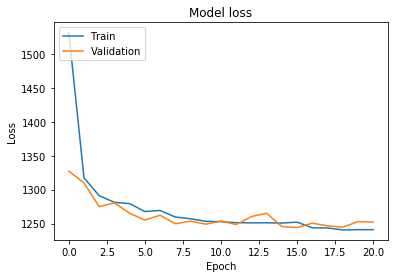

In [25]:
plt.plot(history_adam_regularized.history['loss'])
plt.plot(history_adam_regularized.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# K Nearest Neighbor Regression

In [248]:
# KNN (no parameter tuning)

# Instantiate knn
knn = KNeighborsRegressor(n_neighbors=10, n_jobs = -1)

# Fit knn to the training set
knn.fit(X_train, y_train)

# Predict val set labels
y_pred_knn = knn.predict(X_val)

# Compute val set mae
mae_val_knn = mean_absolute_error(y_val, y_pred_knn)

# Print mae_val
print('val set mae of knn: {:.3f}'.format(mae_val_knn))

val set mae of knn: 1637.178


# Stochastic Gradient Boosting

In [44]:
# stochastic gradient boosting regressor using xgboost (no parameter tuning)

# Instantiate xgbr
xgbr = xgb.XGBRegressor(subsample=0.9,
            colsample_bytree=0.75,
            random_state=SEED, n_jobs = -1)

# Fit xgbr to the training set
xgbr.fit(X_train, y_train)

# Predict val set labels
y_pred_xgbr = xgbr.predict(X_val)

# Compute val set mae
mae_val_xgbr = mean_absolute_error(y_val, y_pred_xgbr)

# Print mae_val
print('val set mae of xgbr: {:.3f}'.format(mae_val_xgbr))

val set mae of xgbr: 1313.556


# Random Forest Regression

In [45]:
#  random forest (no hyperparameter tuning)

# Instantiate rf
rf = RandomForestRegressor(random_state=SEED, n_jobs = -1, verbose = 1, n_estimators = 10)

# Fit rf to the training set
rf.fit(X_train, y_train)

# Predict test set labels
y_pred_rf = rf.predict(X_val)

# Compute mae
mae_test_rf = mean_absolute_error(y_val, y_pred_rf)

# Print mae
print('Test set mae of rf: {:.3f}'.format(mae_test_rf))

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.3min finished


Test set mae of rf: 1172.648


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.5s finished


In [29]:
# save model
pickle.dump(rf, open('../models/rf.sav', 'wb'))

# Support Vector Regression

In [ ]:
#  support vector regression (no hyperparameter tuning)

# Instantiate svr
svr = SVR(kernel='rbf', gamma='auto')

# Fit svr to the training set
svr.fit(X_train, y_train)

# save model
pickle.dump(svr, open('../models/svr.sav', 'wb'))

# Predict test set labels
y_pred_svr = svr.predict(X_val)

# Compute mae
mae_test_svr = mean_absolute_error(y_val, y_pred_svr)

# Print mae
print('Test set mae of svr: {:.3f}'.format(mae_test_svr))

# Extra Trees Regression

In [9]:
#  extra trees regression (no hyperparameter tuning)

# Instantiate etr
etr = ExtraTreesRegressor(n_estimators=100, max_features='auto', verbose=1, n_jobs = -1)

# Fit etr to the training set
etr.fit(X_train, y_train)

# save model
# pickle.dump(etr, open('../models/etr.sav', 'wb'))

# Predict test set labels
y_pred_etr = etr.predict(X_val)

# Compute mae
mae_test_etr = mean_absolute_error(y_val, y_pred_etr)

# Print mae
print('Test set mae of etr: {:.3f}'.format(mae_test_etr))

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 32.9min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.0s


Test set mae of etr: 1031.892


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    7.1s finished


# Elastic Net Regression

In [224]:
# Elastic Net (no hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('st_scaler', StandardScaler()),
         ('enet', ElasticNet(random_state = SEED))]

enet_pipeline = Pipeline(steps)

# fit to the training data
enet_pipeline.fit(X_train, y_train)

# predict the val set labels
y_pred_enet = enet_pipeline.predict(X_val)

# Compute mae_val
mae_val_enet = mean_absolute_error(y_val, y_pred_enet)

# Print mae_val
print('val mae of best model: {:.3f}'.format(mae_val_enet))

val mae of best model: 1576.881


# Predict Using Best Model

In [64]:
y_pred = xgbr.predict(X_test)

In [65]:
y_pred

array([-2897.2427 ,  -279.267  ,  -279.267  , ...,    96.5334 ,
          96.5334 ,  -104.81075], dtype=float32)

In [66]:
y_pred_df = pd.DataFrame(y_pred)

In [67]:
y_pred_df.columns = ['predicted_difference']

In [68]:
y_pred_df.shape

(115064, 1)

In [69]:
y_pred_df.isnull().sum()

predicted_difference    0
dtype: int64

In [70]:
test_file = pd.concat([test.reset_index(drop=True), y_pred_df], axis=1)

In [71]:
test_file.head()

,type,dept,store,month,is_holiday,week_of_year,date,weekly_sales,temperature,fuel_price,...,markdown2_filled_na_scaled,markdown3_filled_na_scaled,markdown4_filled_na_scaled,markdown5_filled_na_scaled,cpi_filled_scaled,unemployment_filled_scaled,median_sales_redone,prev_year_sales,pdt_pred,predicted_difference
0,A,1,1,11,f,44,2012-11-02,0.0,55.32,3.386,...,0.425783,-0.128456,0.077105,-0.137293,1.140481,-0.6632,18870.10,39886.06,0.0,-2897.242676
1,A,1,1,11,f,45,2012-11-09,0.0,61.24,3.314,...,0.167422,-0.129561,0.236814,0.175888,1.140930,-0.6632,18870.10,18689.54,0.0,-279.266998
2,A,1,1,11,f,46,2012-11-16,0.0,52.92,3.252,...,-0.280257,-0.122902,-0.320508,0.217917,1.141697,-0.6632,18870.10,19050.66,0.0,-279.266998
3,A,1,1,11,t,47,2012-11-23,0.0,56.23,3.211,...,-0.322124,7.721394,-0.466949,-0.360404,1.142886,-0.6632,18820.29,20911.25,0.0,-328.704651
4,A,1,1,12,t,52,2012-12-28,0.0,44.79,3.108,...,5.072046,-0.115457,-0.488434,-0.277402,1.152551,-0.6632,19124.58,23350.88,0.0,-279.266998


In [72]:
# test_file['prediction'] = test_file['predicted_difference']
test_file['prediction'] = test_file['median_sales_fillna'] - test_file['predicted_difference']

In [73]:
test_file['prediction'].isnull().sum()

0

In [74]:
test_file.head()

,type,dept,store,month,is_holiday,week_of_year,date,weekly_sales,temperature,fuel_price,...,markdown3_filled_na_scaled,markdown4_filled_na_scaled,markdown5_filled_na_scaled,cpi_filled_scaled,unemployment_filled_scaled,median_sales_redone,prev_year_sales,pdt_pred,predicted_difference,prediction
0,A,1,1,11,f,44,2012-11-02,0.0,55.32,3.386,...,-0.128456,0.077105,-0.137293,1.140481,-0.6632,18870.10,39886.06,0.0,-2897.242676,22448.357676
1,A,1,1,11,f,45,2012-11-09,0.0,61.24,3.314,...,-0.129561,0.236814,0.175888,1.140930,-0.6632,18870.10,18689.54,0.0,-279.266998,19830.381998
2,A,1,1,11,f,46,2012-11-16,0.0,52.92,3.252,...,-0.122902,-0.320508,0.217917,1.141697,-0.6632,18870.10,19050.66,0.0,-279.266998,19830.381998
3,A,1,1,11,t,47,2012-11-23,0.0,56.23,3.211,...,7.721394,-0.466949,-0.360404,1.142886,-0.6632,18820.29,20911.25,0.0,-328.704651,20194.474651
4,A,1,1,12,t,52,2012-12-28,0.0,44.79,3.108,...,-0.115457,-0.488434,-0.277402,1.152551,-0.6632,19124.58,23350.88,0.0,-279.266998,21516.996998


In [75]:
test_file.shape

(115064, 273)

In [76]:
submission_df = pd.DataFrame({
                    'id': test_file.store.astype(str) + '_' + test_file.dept.astype(str) + '_' + test_file.date.astype(str),
                    'Weekly_Sales': test_file.prediction})

In [77]:
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 2 columns):
id              115064 non-null object
Weekly_Sales    115064 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.8+ MB


In [78]:
submission_df.head()

,id,Weekly_Sales
0,1_1_2012-11-02,22448.357676
1,1_1_2012-11-09,19830.381998
2,1_1_2012-11-16,19830.381998
3,1_1_2012-11-23,20194.474651
4,1_1_2012-12-28,21516.996998


In [79]:
submission_df.sort_values(by = 'id').head()

,id,Weekly_Sales
10269,10_10_2012-11-02,44320.577776
10270,10_10_2012-11-09,44256.977617
10271,10_10_2012-11-16,44256.977617
10272,10_10_2012-11-23,44894.892457
50240,10_10_2012-11-30,43719.810259


In [80]:
submission_df.isnull().sum()

id              0
Weekly_Sales    0
dtype: int64

In [81]:
submission_df.to_csv('../data/submission.csv',index=False)